# TP Analyse de l'enrichissement en pathway Gene Ontology


## Jeux de données
* Experimental dataset as TSV
* Go ontology as [owl](http://www.obofoundry.org/ontology/go.html)
* Uniprot entries as XML files
* Statistical library to perform OverRepresentationAnalysis

### Construction de l'analyse d'enrichissement en termes GO
* **Questions:**
    * Les protéines très abondantes présentent-elles des termes GO en quantité remarquable ?
    * Les protéines peu abondantes présentent-elles des termes GO en quantité remarquable ?

1. Découverte de la modélisation hypergéometrique des fréquences attendues des termes GO
2. Utilisation d'un test d'enrichissement d'un terme GO
3. Affichage **riche** des resultats du test dans le notebook et dans des voclanos plots

## Ressources
https://www.bioconductor.org/help/course-materials/2015/SeattleApr2015/E_GeneSetEnrichment.html

In [5]:
import sys, os
workDir = f"{os.getcwd()}/.."
libDir = f"{workDir}/lib"
dataDir= f"{workDir}/data" 

sys.path.append(libDir)

In [4]:
libDir

'/Users/guillaumelaunay/work/enseignements/current_content/UCBL/Bioinformatics/M2/_VDB/VDB_jupyter/solutions/../../lib'

In [2]:
%load_ext autoreload
%autoreload 2

In [6]:
import pandas, uniprot, go
import numpy as np

* Owlready2 * Warning: optimized Cython parser module 'owlready2_optimized' is not available, defaulting to slower Python implementation


In [7]:
%matplotlib nbagg
import matplotlib.pyplot as plt

### Lecture des valeurs experimentales
Charger ```TCL_wt1.tsv``` dans une [dataframe pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).
* Retirer les lignes présentant des aberrations numériques
* Créer une DataFrame ne contenant que les lignes où **Log2 Corrected Abundance Ratio** > 0

In [11]:
import pandas
import numpy as np

df=pandas.read_csv(workDir + "/TCL_wt1.tsv", delimiter ="\t", na_values="#VALEUR!",
                  dtype= {"Accession": str, "Description" : str, "GeneSymbol": str,
                             "Corrected Abundance ratio (1.53)": np.float64,
                              "Log2 Corrected Abundance Ratio" : np.float64,
                              "Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT)" : np.float64,
                              "LOG10 Adj.P-val" : np.float64
                             }).dropna()
df.head()

,Accession,Description,Gene Symbol,Corrected Abundance ratio (1.53),Log2 Corrected Abundance Ratio,Abundance Ratio Adj. P-Value: (127. T3 Tc WT) / (126. T0 WT),LOG10 Adj.P-val
0,P75936,Basal-body rod modification protein FlgD OS=Es...,flgD,0.075817,-3.721335,0.000055,4.260067
1,P76231,Uncharacterized protein YeaC OS=Escherichia co...,yeaC,0.092810,-3.429569,0.000351,3.454627
2,P0A8S9,Flagellar transcriptional regulator FlhD OS=Es...,flhD,0.102614,-3.284695,0.000027,4.571899
4,P05706,PTS system glucitol/sorbitol-specific EIIA com...,srlB,0.108497,-3.204277,0.019963,1.699768
5,P29744,Flagellar hook-associated protein 3 OS=Escheri...,flgL,0.124183,-3.009460,0.036746,1.434787


### Un premier volcano-plot

Réaliser un scatter plot matplotlib avec 
- en x, `Log2 Corrected Abundance Ratio`
- en y, `LOG10 Adj.P-val`
Vous légenderez les axes, attention `LOG10 Adj.P-val` est en fait `-LOG10 Adj.P-val`, regardez bien.

<IPython.core.display.Javascript object>


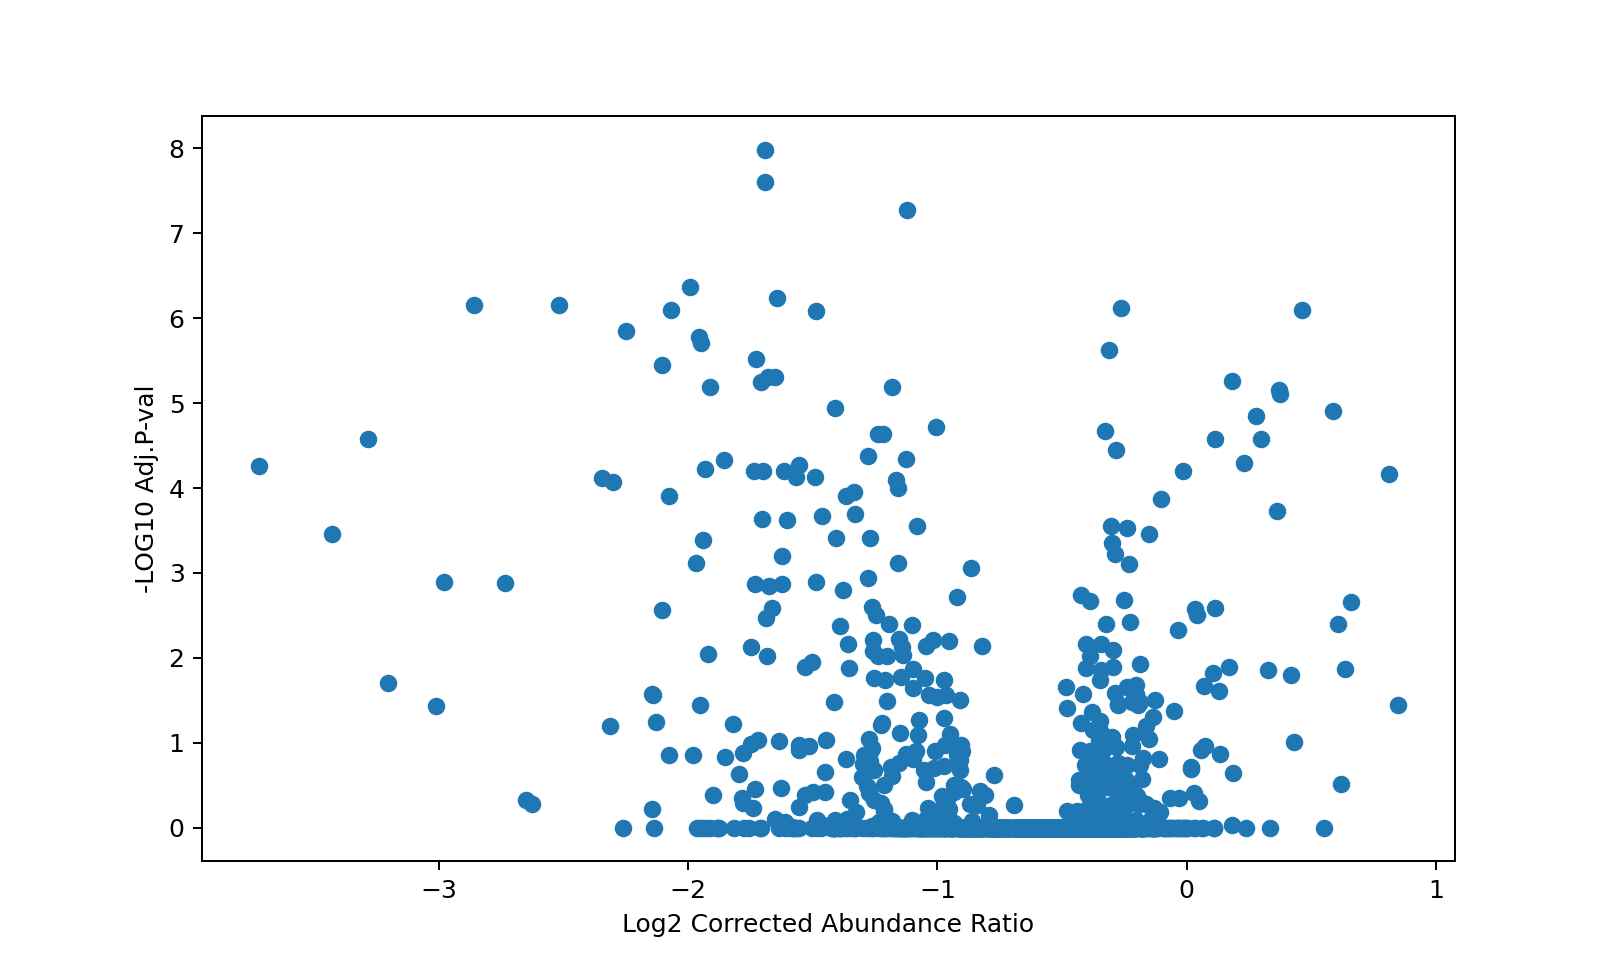

Text(0, 0.5, '-LOG10 Adj.P-val')

In [25]:
f1, f1_ax = plt.subplots(figsize=(5,3), ncols=1, nrows=1)
f1_ax.scatter(df['Log2 Corrected Abundance Ratio'], df['LOG10 Adj.P-val'])
f1_ax.set_xlabel('Log2 Corrected Abundance Ratio')
f1_ax.set_ylabel('-LOG10 Adj.P-val')

In [ ]:
goFile = f"{dataDir}/go.owl"
proteomeDirectory= f"{dataDir}/K12_proteome"
experimentalProteinDirectory= f"{dataDir}/dataset"
analyser = GO_ORA_analyser(goFile, proteomeDirectory, experimentalProteinDirectory)

#### Analyse ORA

##### Principes
Vous disposez d'un objet analyser permettant de réaliser une analyse de la sur-représentation (**ORA**) en termes GO parmi une liste de protéine d'intérêt.
La fréquence des termes GO dans le protéome totale est utilisée comme référence.

L'objet analyser s'instancie ainsi
```python
from stat_utils import GO_ORA_analyser
o = GO_ORA_analyser(goFile, proteomeDirectory, experimentalProteinDirectory)
```

Il fournit une méthode par catégorie de terme GO
biological_process / molecular_function /cellular_component
par exemple,
```python
goTerm_scores = o.biological_process([P29744, P05706])
```
Réalise une analyse de sur-représentation des termes GO entre `[P29744, P05706]` par rapport au protéome d.E.Coli.

Inspectez l'objet retourné par la méthode o.biological_process, que voyez-vous ?

In [32]:
saList = df[ df['Log2 Corrected Abundance Ratio'] > 0.245 ]['Accession'].tolist()
a = analyser.biological_process(saList)
b = analyser.molecular_function(saList)
c = analyser.cellular_component(saList)

## Une première application: représentation riche du résultat de l'analyse


### Mise en forme "riche" des résultats grâce au notebook

Jupyter permet d'étendre le concept de la méthode **__str__()** afin de produire du contenu HTML.
 Ainsi, tout objet impémentant une méthode **_repr_html_()** sera affiché, via son rendu HTML, dans la cellule d'un notebook.

```python
class Point():
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    def _repr_html_(self):
        htmlString = "<table><thead><tr><td>Abscisse</td><td>Ordonnée</td><td>Cote</td></tr></thead>"
        htmlString += f"<tbody><tr><td>{self.x}</td><td>{self.y}</td><td>{self.z}</td></tr></tbody></table>"
        return htmlString
Point(2,3,4)
```
Affichera

![caption](../figs/reprhtml.png)


### Intégration des résultats à la visualisation du notebook 

En vous inspirant de la fonction ci-dessus, implémenter une classe Rich_GO_ORA dont la méthode [`_repr_html_`](https://ipython.readthedocs.io/en/stable/config/integrating.html) permettra un affichage plus lisible d'une analyse `biological_process / molecular_function /cellular_component`

Un exemple possible est,
![caption](../figs/_repr_html_.png)

(Bonus): clicker sur le nom du terme GO envoie vers sa description.
Pour cela, afficher le nom du pathway dans une balise hyperlien pour permettre d'acceder à la page de description du terme GO. 

Les termes GO sont accessibles aux URL de la forme
`http://amigo.geneontology.org/amigo/term/GO:GO_NUMBER`.




In [ ]:
#####

## Une deuxième application: volcano plot améliorés
###### PANDAS
En choisissant comme seuil la valeur `alpha` du TP précédent, veuillez extraires les identifiants uniprot des protéines sur-abondantes (rappel les valeurs d'abondance sont celles de la colonne `Log2 Corrected Abundance Ratio`).

Vous devrez avoir dans des listes distinctes:
* identifiants uniprot
* `Log2 Corrected Abundance Ratio`
* `LOG10 Adj.P-val'`

###### Représentation graphiques
* Pour la catégorie de termes GO (biological_process / molecular_function /cellular_component) de votre choix
    * Générer une grille de 4 graphiques 
    * Dans chaque graphique colorez dans une couleur différentes les protéines porteuses de 4 termes de GO que vous estimez les plus pertinents 
    * Donnez le nom de la catégorie générale à la grille
    * Donnez le nom du terme GO représenté dans chaque graphique avec une couleur de titre cohérente.
    

Evaluated 109 / 262 Pathways, based on 18 proteins
Evaluated 42 / 92 Pathways, based on 18 proteins
Evaluated 29 / 51 Pathways, based on 18 proteins
